In [50]:
import os 
import glob 

import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from math import sqrt

from metpy.calc import wind_speed
from metpy.calc import wind_direction 
from metpy.units import units

import matplotlib.pyplot as plt
from   matplotlib.lines import Line2D
import seaborn as sns
from upsetplot import UpSet, from_indicators

# Functions

In [2]:
def get_wind(df): 
    u = df['U10'].values * units('m/s')
    v = df['V10'].values * units('m/s')

    df['WND_SPD'] = wind_speed(u,v)
    df['WND_DIR'] = wind_direction(u, v, convention='from')
    
    return df

def prep_data(datadir, fname):
    df = pd.read_pickle(os.path.join(datadir, fname))
    df['T2'] = df['T2'] - 273  # Convert K to C
    df.index = df.index - pd.Timedelta(hours=8)  # UTC to local
    df = get_wind(df)  # Get wind speed/direction from components
    
    return df

# Read in and prepare data

In [3]:
#### WRF data ####
datadir = '/home/patmccornack/data/wrf_extracted/interpolated_v2'
wsauc_fname = 'wrf_sauc_2003-2010.pkl'
wsauc = prep_data(datadir, wsauc_fname)
wsauc.head()

,DFGDP,T2,Q2,PSFC,U10,V10,LWUPB,LWDNB,SWUPB,SWDNB,RH,WND_SPD,WND_DIR
times,,,,,,,,,,,,,
2002-06-30 16:00:00,0.0,16.739721,0.010619,98340.050281,1.872795,2.350064,0.000000,0.000000,0.000000,0.000000,87.413706,3.005023,218.551773
2002-06-30 17:00:00,0.0,18.949653,0.010380,98291.891475,-0.291864,0.210433,459.280270,334.343107,56.658686,387.258722,74.233599,0.359815,125.791428
2002-06-30 18:00:00,0.0,19.076010,0.010831,98242.852066,1.758425,-1.346994,443.047461,323.430480,31.885162,211.141588,76.805488,2.215051,307.452943
2002-06-30 19:00:00,0.0,17.662336,0.009881,98220.388056,1.893184,-1.578387,419.186600,315.142696,4.143514,25.954519,76.599042,2.464843,309.818659
2002-06-30 20:00:00,0.0,16.012562,0.009639,98229.194142,1.297025,-1.676641,402.394090,309.095212,0.000000,0.000000,83.041134,2.119764,322.274999


In [4]:
#### Observational data
odatadir = '/home/patmccornack/data/preprocessed'
osauc_fname = 'SAUC_hourly.csv'
osauc = pd.read_csv(os.path.join(odatadir, osauc_fname))
osauc.set_index('time (PST)', inplace = True)
osauc.head()

,fog drip,rain (mm),wind gust (m/s),air temperature (C),relative humidity (%),wind speed (m/s),wind direction (deg)
time (PST),,,,,,,
2003-12-19 16:00:00,0.0,0.0,0.95,15.53,27.54,0.63,92.21
2003-12-19 17:00:00,0.0,0.0,3.96,15.22,27.05,1.40,99.26
2003-12-19 18:00:00,0.0,0.0,3.75,14.68,32.86,2.07,140.33
2003-12-19 19:00:00,0.0,0.0,3.51,12.89,60.68,2.22,122.58
2003-12-19 20:00:00,0.0,0.0,4.60,13.53,49.79,2.62,119.99


In [5]:
#### Create fog variable based on radiation ####
wsauc['rad_fog'] = wsauc['LWDNB'].apply(lambda x: 1 if x > 360 else 0)

#### Extract just fog variables ####
df = wsauc[['DFGDP', 'rad_fog']].join(osauc['fog drip'], how='inner')

### Convert all values to boolean and get agreement count
df['DFGDP'] = df['DFGDP'].apply(lambda x: 1 if x > 0 else 0)
df['fog drip'] = df['fog drip'].apply(lambda x: 1 if x > 0 else 0)
df['count'] = df.sum(axis=1)

df.head(3)

,DFGDP,rad_fog,fog drip,count
2003-12-19 16:00:00,0,0,0,0
2003-12-19 17:00:00,0,0,0,0
2003-12-19 18:00:00,0,0,0,0


# Compare Fog Inference Methods

<Figure size 1080x1080 with 0 Axes>

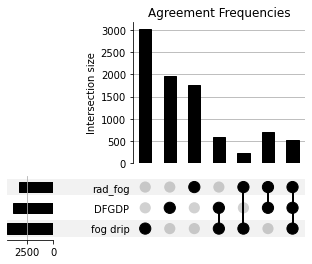

In [57]:
#### Make Upset Plot ####
tmp = df.reset_index()
bool_matrix = tmp[['DFGDP', 'rad_fog', 'fog drip']].astype(bool)
bool_matrix = bool_matrix.loc[bool_matrix.any(axis=1)]  # Drops rows with all false
upset_data = from_indicators(['DFGDP', 'rad_fog', 'fog drip'], bool_matrix)
plt.figure(figsize=(15, 15))
UpSet(upset_data, subset_size='count').plot()
plt.title("Agreement Frequencies")
plt.show()

In [ ]:
# Compare summer fog data
def plot_summer_comp(wrf_df, obs_df, daterange, site):
    ## Create subsets of data
    year = daterange[0].split('-')[0]
    wrf_df = wrf_df[daterange[0]:daterange[1]]
    obs_df = obs_df[daterange[0]:daterange[1]]
    
    bar_width = 0.05

    ## Make Plots
    fig, ax = plt.subplots(2, 1, figsize=(20, 6))
    ax[0].bar(wrf_df.index, wrf_df['DFGDP'], label='Fog', width=bar_width)
    wrh_ax = ax[0].twinx()
    wrh_ax.plot(wrf_df.index, wrf_df['RH'], color='green', alpha=0.5, label='RH')
    
    ax[1].bar(obs_df.index, obs_df['fog drip'], color='red', label='Fog', width=bar_width)
    orh_ax = ax[1].twinx()
    orh_ax.plot(obs_df.index, obs_df['relative humidity (%)'], color='orange', alpha=0.5, label='RH')

    
    ax[0].set(title=f'{site} WRF {year}')
    ax[1].set(title=f'{site} Observational {year}')

    plt.tight_layout()
    plt.show()